In [1]:
import numpy as np
import pandas as pd
from scipy.stats import spearmanr, pearsonr
from scipy.stats import zscore
from scipy.special import logit
import seaborn as sns
from tqdm import tqdm
from statsmodels.stats.multitest import multipletests
import matplotlib.pyplot as plt
from IPython.core.pylabtools import figsize
from sklearn.neighbors import NearestNeighbors

from sklearn.metrics import jaccard_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import fowlkes_mallows_score
from sklearn.metrics import adjusted_rand_score
from sklearn.cluster import AgglomerativeClustering as AC
from sklearn.cluster import KMeans as KM
from scipy.stats import hypergeom


%run -i 'analysis_utils.py'

100%|██████████| 202/202 [00:01<00:00, 167.57it/s]


In [366]:
def cluster_pseudotime(cluster, psi_table, pseudotime, window=10):
    order = pseudotime.loc[psi_table.columns].sort_values('lineage_1_pseudotime').lineage_1_pseudotime.dropna()
    cells = order.index
    exon_df = pd.DataFrame()
    
    order_matrix = pd.DataFrame(np.zeros((len(cells), len(cells))))
    order_matrix.index = cells
    order_matrix.columns = cells

    for i in range(len(cells)-window+1):
        cell_slice = cells[i:i+window]
        

        order_matrix.loc[cells[i], cell_slice] = 1
    
    counter = 1
    
    pseudotime_avg = (order_matrix * pseudotime.loc[cells].lineage_1_pseudotime).mask(order_matrix==0).mean(axis=1).dropna()
    
    for exon in tqdm(cluster):
        psi_exon_slice = psi_table.loc[exon, cells]
        exon_avg = (psi_exon_slice*order_matrix).mask(order_matrix==0).mean(axis=1).dropna()
        
            
        exon_df[exon] = exon_avg
        
    return exon_df, pseudotime_avg
        

In [387]:
regulator_expression, pseudotime_avg = cluster_pseudotime(
    ['Ptbp1', 'Ptbp2', 'Nova1', 'Nova2', 'Rbfox1', 'Rbfox2', 'Rbfox3', 'Mbnl1', 'Mbnl2'], 
    np.log10(tiklova_mrna+1), tiklova_pseudotime, window=200)

100%|██████████| 9/9 [00:05<00:00,  1.54it/s]


In [388]:
regulator_expression_norm, pseudotime_avg = cluster_pseudotime(
    ['Ptbp1', 'Ptbp2', 'Nova1', 'Rbfox1', 'Rbfox2', 'Rbfox3', 'Mbnl1', 'Mbnl2'], 
    tiklova_norm, tiklova_pseudotime, window=200)

100%|██████████| 8/8 [00:05<00:00,  1.59it/s]


Text(0.5, 1.0, 'Key regulators expression')

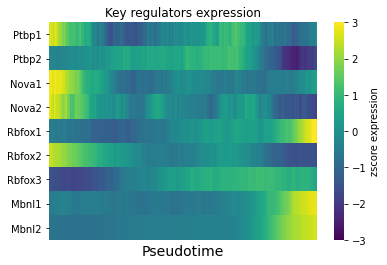

In [405]:
smooth_expression = pd.DataFrame(zscore(regulator_expression.T, axis=1))
smooth_expression.index = ['Ptbp1', 'Ptbp2', 'Nova1', 'Nova2', 'Rbfox1', 'Rbfox2', 'Rbfox3', 'Mbnl1', 'Mbnl2']
g = sns.heatmap(smooth_expression, cmap='viridis', vmin=-3, vmax=3, xticklabels=False, 
                cbar_kws={'label': 'zscore expression'})

g.tick_params(bottom=False)
plt.xlabel('Pseudotime', fontsize=14)
plt.title('Key regulators expression')

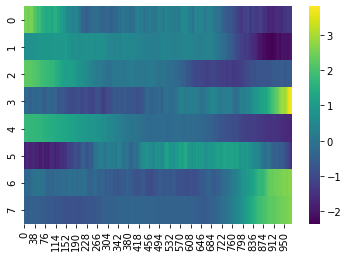

In [391]:
sns.heatmap(zscore(regulator_expression_norm.T, axis=1), cmap='viridis')

In [3]:
exons_sig = tiklova_psix.index[tiklova_psix.qvals <= 0.05]
ordered_cells = tiklova_pseudotime.loc[tiklova_rd.index].lineage_1_pseudotime.dropna().sort_values().index
tiklova_PSI_corr = tiklova_PSI.loc[exons_sig].T.corr()

/mnt/lareaulab/cfbuenabadn/anaconda3/lib/python3.7/site-packages/seaborn/matrix.py:624: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


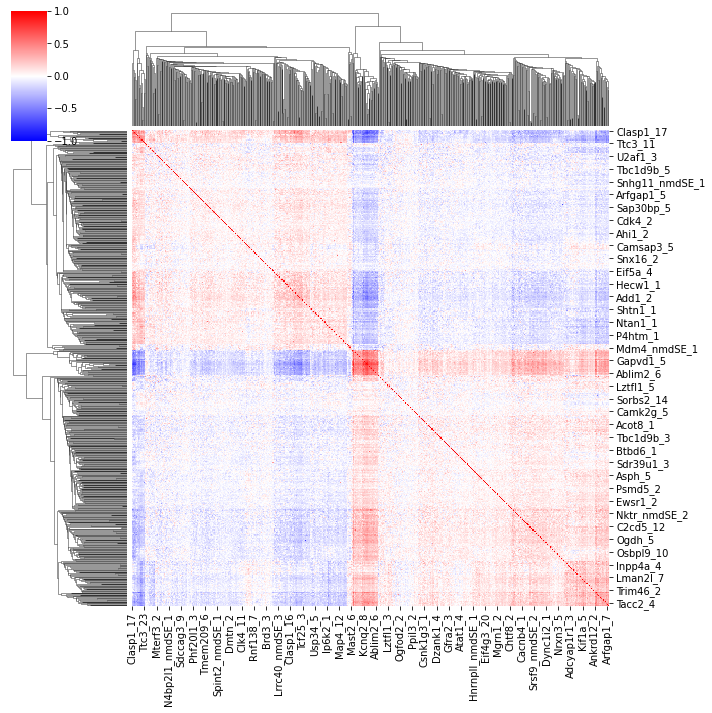

In [4]:
sns.clustermap(tiklova_PSI_corr.fillna(0), cmap='bwr', vmin=-1, vmax=1)

In [5]:
clusters_corr = AC(n_clusters=8).fit_predict(tiklova_PSI_corr.fillna(0))
clusters_corr_dict = {}
for i in range(8):
    clusters_corr_dict.update({i:tiklova_PSI_corr.loc[clusters_corr == i].index})

100%|██████████| 212/212 [01:30<00:00,  2.33it/s]


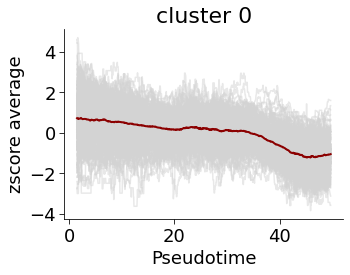

100%|██████████| 131/131 [00:52<00:00,  2.52it/s]


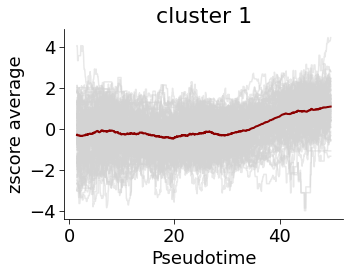

100%|██████████| 48/48 [00:19<00:00,  2.52it/s]


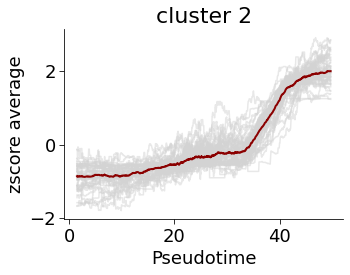

100%|██████████| 35/35 [00:14<00:00,  2.41it/s]


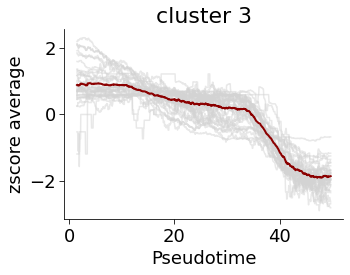

100%|██████████| 78/78 [00:31<00:00,  2.51it/s]


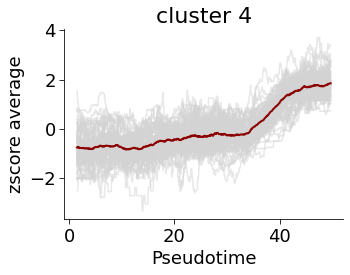

100%|██████████| 93/93 [00:40<00:00,  2.28it/s]


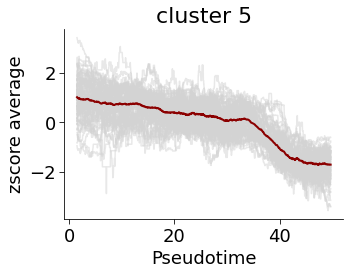

100%|██████████| 118/118 [00:47<00:00,  2.51it/s]


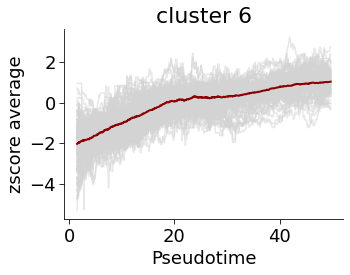

100%|██████████| 30/30 [00:14<00:00,  2.02it/s]


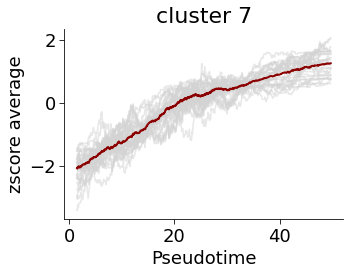

In [75]:
clusters_corr = AC(n_clusters=8).fit_predict(tiklova_PSI_corr.fillna(0))
clusters_corr_dict = {}
for i in range(8):
    clusters_corr_dict.update({i:tiklova_PSI_corr.loc[clusters_corr == i].index})
    
    
zscore_table = pd.DataFrame()
    
for cluster in clusters_corr_dict.keys():
    
    figsize(5,3.5)
    fig = plt.figure()
    ax  = plt.subplot(1,1,1)
    
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)

    cluster_df, pseudotime_avg = cluster_pseudotime(clusters_corr_dict[cluster], tiklova_PSI, pseudotime, window=100)
    zscore_avg = pd.DataFrame()
    for exon in cluster_df.columns:
        ax.plot(pseudotime_avg, zscore(cluster_df[exon]), c='lightgray', alpha=0.5)
        zscore_avg[exon] = zscore(cluster_df[exon])
        
    ax.plot(pseudotime_avg, zscore_avg.mean(axis=1), c='darkred', linewidth=2)
    
    
    ax.tick_params(labelsize=18, length=5)

    plt.xlabel('Pseudotime', fontsize=18)
    plt.ylabel('zscore average', fontsize=18)
    plt.title('cluster '+str(cluster), fontsize=22)


    plt.show()
    
    zscore_table = pd.concat([zscore_table, zscore_avg], axis=1, sort=False)
    

In [6]:
mouse_RBP = pd.read_csv('~/Network/Mouse/SplicingNetwork/L_score_events/tiklova/peaks_predicted_mRBP.tab', 
                        sep='\t', index_col=0)

human_RBP = pd.read_csv('~/Network/Mouse/SplicingNetwork/L_score_events/tiklova_hRBP/peaks_predicted_hRBP.tab', 
                        sep='\t', index_col=0)

mouse_RBP_binary = (mouse_RBP >= 1).astype(int)
human_RBP_binary = (human_RBP >= 1).astype(int)

mouse_RBP_se = mouse_RBP_binary.loc[[x for x in mouse_RBP.index if '_se' in x]]
mouse_RBP_e1 = mouse_RBP_binary.loc[[x for x in mouse_RBP.index if '_e1' in x]]
mouse_RBP_e2 = mouse_RBP_binary.loc[[x for x in mouse_RBP.index if '_e2' in x]]

human_RBP_se = human_RBP_binary.loc[[x for x in human_RBP.index if '_se' in x]]
human_RBP_e1 = human_RBP_binary.loc[[x for x in human_RBP.index if '_e1' in x]]
human_RBP_e2 = human_RBP_binary.loc[[x for x in human_RBP.index if '_e2' in x]]

mouse_RBP_se.index = [x[:-3] for x in mouse_RBP_se.index]
mouse_RBP_e1.index = [x[:-3] for x in mouse_RBP_e1.index]
mouse_RBP_e2.index = [x[:-3] for x in mouse_RBP_e2.index]

human_RBP_se.index = [x[:-3] for x in human_RBP_se.index]
human_RBP_e1.index = [x[:-3] for x in human_RBP_e1.index]
human_RBP_e2.index = [x[:-3] for x in human_RBP_e2.index]

In [7]:
mouse_RBP_se.SRSF3.mean()

0.7074640704682429

In [18]:
mouse_RBP_se.RBFOX2.mean()

0.18961520630505332

In [30]:
mouse_RBP_se.loc[clusters_corr_dict[7]].RBFOX2.mean()

0.36666666666666664

In [116]:
human_RBP_binary.loc[se].sum(axis=0)

RBM47         1047
RBM5           861
SRSF10        1036
SRSF1          888
SRSF3         1573
SRSF7          830
SRSF9          800
ELAVL1         986
PTBP1PTBP2    1327
RBFOX2        1121
RBM10          805
RBM15          604
RBM22         1087
RBM27          590
dtype: int64

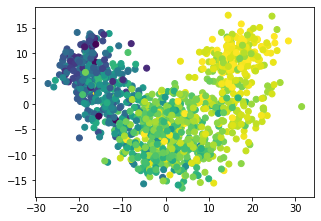

In [99]:
plt.scatter(tiklova_rd.PC_1, tiklova_rd.PC_2, c=tiklova_PSI.loc[clusters_corr_dict[7]].mean(axis=0))

In [7]:
tiklova_cross_psix = pd.read_csv('../psix_runs/tiklova_neurogenesis.cross_scores.tab', sep='\t', index_col=0)

modules_psix = pd.read_csv('old_files/tiklova_modules.tab', sep='\t', index_col=0)
modules_psix_2 = pd.read_csv('old_files/modules.tab', sep='\t', index_col=0)

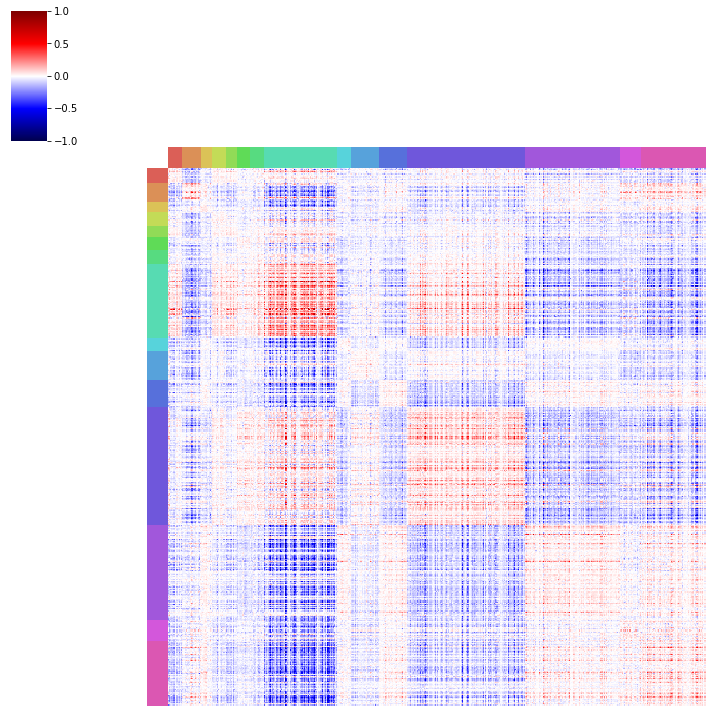

In [8]:
idx = [x.split(':')[0] for x in modules_psix_2]
modules_psix_2.index = idx
modules_psix_2.columns = idx

# css_out = get_modules(cross_super_sig, 0.01)
clusters = {}
counter = 0
for cluster in modules_psix.index:
    list_to_add = sorted(set(cluster.split(',')))
    if len(list_to_add) >= 10:
        clusters.update({counter:list_to_add})
        counter += 1
        
        
exons_list = []
for i in range(len(clusters.keys())):
# for i in [4, 0, 2, 3, 5, 1]:
    exons_list.extend(clusters[i])
    
colores = sns.color_palette("hls", 16)
exons_list = []
color_list = []
for i in range(len(clusters.keys())):
# for i in [5, 3, 0, 2, 6, 4, 1]:
# for i in [13, 1, 8, 14, 2, 10, 12, 9, 6, 5, 4, 3, 0, 11, 7]:
    exons_list.extend(clusters[i])
    color_list.extend([colores[i]]*len(clusters[i]))
    
sns.clustermap(tiklova_cross_psix.loc[exons_list, exons_list], col_cluster=False, row_cluster=False,
               col_colors=color_list, row_colors = color_list, cmap='seismic', vmin=-1, vmax=1,
              yticklabels=0, xticklabels=0)

In [9]:
def hyper_test(M, n, N, k):
    '''
    Calculates the hypergeometric test.
    
    Input:
      M: Population size (total exons tested)
      n: Successess in population (exons with p-value <= x)
      N: Sample size (exons selected)
      k: Successes in sample (selected exons with p-value <= x)
    Output:
      p_depleted: p-value of depletion from the hypergeometric test
      p_enriched: p-value of enrichment from the hypergeometric test
    '''
    hpd = hypergeom(M, n, N) # Hypergeometric distribution
    p_depleted = hpd.cdf(k)  # Get cummulative distribution up to k
    p_enriched = hpd.sf(k-1) # Survival function up to k-1 (1 - cdf(k-1))
    return p_depleted, p_enriched

def hypergeom_cluster_test(rbp_binding, clusters):
    
    pval = hyper_test(len(rbp_binding.index), rbp_binding.sum(), len(clusters), rbp_binding.loc[clusters].sum())
    
    if rbp_binding.loc[clusters].sum() >= 1:
        return pval[1]
    else:
        return np.nan
    
#     if (rbp_binding.loc[clusters].sum()/len(clusters)) > (rbp_binding.sum()/len(rbp_binding.index)):
    
#         return pval[1]
#     else:
#         return pval[1]

In [44]:
x = ['RBFOX1', 'RBFOX2', 'RBFOX3',
       'MBNL1MBNL2', 'MBNL2', 'NOVA1', 'NOVA2', 'PTBP1']

In [33]:
from statsmodels.stats.multitest import multipletests

In [257]:
# clusters_corr = AC(n_clusters=8).fit_predict(tiklova_PSI_corr.fillna(0))
# clusters = {}
# for i in range(8):
#     clusters.update({i:tiklova_PSI_corr.loc[clusters_corr == i].index})

clusters = {}
counter = 0
for cluster in modules_psix.index:
    list_to_add = sorted(set(cluster.split(',')))
    if len(list_to_add) >= 10:
        clusters.update({counter:list_to_add})
        counter += 1

pval_list_mouse = []
clust_list = clusters.keys()
clusters_pval_se = pd.DataFrame(np.zeros((len(clusters.keys()), len(x))))
clusters_pval_e1 = pd.DataFrame(np.zeros((len(clusters.keys()), len(x))))
clusters_pval_e2 = pd.DataFrame(np.zeros((len(clusters.keys()), len(x))))

clusters_pval_se.index = clust_list
clusters_pval_se.columns = x

clusters_pval_e1.index = clust_list
clusters_pval_e1.columns = x

clusters_pval_e2.index = clust_list
clusters_pval_e2.columns = x


for c in clust_list:
#     for rbp in mouse_RBP_se.columns:
    for rbp in x:
        
        se_pval = hypergeom_cluster_test(mouse_RBP_se[rbp], clusters[c])
        e1_pval = hypergeom_cluster_test(mouse_RBP_e1[rbp], clusters[c])
        e2_pval = hypergeom_cluster_test(mouse_RBP_e2[rbp], clusters[c])
        
        clusters_pval_se.loc[c, rbp] = se_pval
        clusters_pval_e1.loc[c, rbp] = e1_pval
        clusters_pval_e2.loc[c, rbp] = e2_pval
        
        pval_list_mouse += [se_pval, e1_pval, e2_pval]
        


In [338]:
mouse_RBP_combined_se = pd.DataFrame()
mouse_RBP_combined_se['RBFOX'] = (mouse_RBP_se[['RBFOX1', 'RBFOX2', 'RBFOX3']].sum(axis=1) >= 1).astype(int)
mouse_RBP_combined_se['MBNL'] = (mouse_RBP_se[['MBNL1MBNL2', 'MBNL1']].sum(axis=1) >= 1).astype(int)
mouse_RBP_combined_se['NOVA'] = (mouse_RBP_se[['NOVA1', 'NOVA2']].sum(axis=1) >= 1).astype(int)
mouse_RBP_combined_se['PTBP'] = mouse_RBP_se['PTBP1']

mouse_RBP_combined_e1 = pd.DataFrame()
mouse_RBP_combined_e1['RBFOX'] = (mouse_RBP_e1[['RBFOX1', 'RBFOX2', 'RBFOX3']].sum(axis=1) >= 1).astype(int)
mouse_RBP_combined_e1['MBNL'] = (mouse_RBP_e1[['MBNL1MBNL2', 'MBNL1']].sum(axis=1) >= 1).astype(int)
mouse_RBP_combined_e1['NOVA'] = (mouse_RBP_e1[['NOVA1', 'NOVA2']].sum(axis=1) >= 1).astype(int)
mouse_RBP_combined_e1['PTBP'] = mouse_RBP_e1['PTBP1']

mouse_RBP_combined_e2 = pd.DataFrame()
mouse_RBP_combined_e2['RBFOX'] = (mouse_RBP_e2[['RBFOX1', 'RBFOX2', 'RBFOX3']].sum(axis=1) >= 1).astype(int)
mouse_RBP_combined_e2['MBNL'] = (mouse_RBP_e2[['MBNL1MBNL2', 'MBNL1']].sum(axis=1) >= 1).astype(int)
mouse_RBP_combined_e2['NOVA'] = (mouse_RBP_e2[['NOVA1', 'NOVA2']].sum(axis=1) >= 1).astype(int)
mouse_RBP_combined_e2['PTBP'] = mouse_RBP_e2['PTBP1']

In [355]:
clusters_corr = AC(n_clusters=8).fit_predict(tiklova_PSI_corr.fillna(0))
clusters = {}
for i in range(8):
    clusters.update({i:tiklova_PSI_corr.loc[clusters_corr == i].index})

# clusters = {}
# counter = 0
# for cluster in modules_psix.index:
#     list_to_add = sorted(set(cluster.split(',')))
#     if len(list_to_add) >= 10:
#         clusters.update({counter:list_to_add})
#         counter += 1

x = ['RBFOX', 'MBNL', 'NOVA', 'PTBP']

pval_list_mouse = []
clust_list = clusters.keys()
clusters_pval_se = pd.DataFrame(np.zeros((len(clusters.keys()), len(x))))
clusters_pval_e1 = pd.DataFrame(np.zeros((len(clusters.keys()), len(x))))
clusters_pval_e2 = pd.DataFrame(np.zeros((len(clusters.keys()), len(x))))

clusters_pval_se.index = clust_list
clusters_pval_se.columns = x

clusters_pval_e1.index = clust_list
clusters_pval_e1.columns = x

clusters_pval_e2.index = clust_list
clusters_pval_e2.columns = x


for c in clust_list:
    for rbp in mouse_RBP_combined_se.columns:
#     for rbp in x:
        
        se_pval = hypergeom_cluster_test(mouse_RBP_combined_se[rbp], clusters[c])
        e1_pval = hypergeom_cluster_test(mouse_RBP_combined_e1[rbp], clusters[c])
        e2_pval = hypergeom_cluster_test(mouse_RBP_combined_e2[rbp], clusters[c])
        
        clusters_pval_se.loc[c, rbp] = se_pval
        clusters_pval_e1.loc[c, rbp] = e1_pval
        clusters_pval_e2.loc[c, rbp] = e2_pval
        
        pval_list_mouse += [se_pval, e1_pval, e2_pval]
        


/mnt/lareaulab/cfbuenabadn/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/mnt/lareaulab/cfbuenabadn/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


Text(0.5, 1.0, 'RBP enrichment, all')

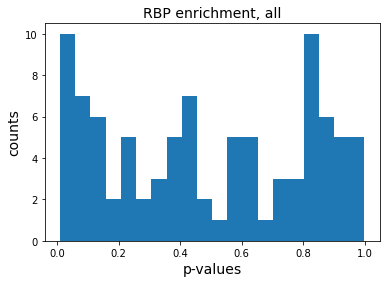

In [356]:
# plt.hist(pval_list_mouse, bins=20)
# plt.xlabel('p-values', fontsize=14)
# plt.ylabel('counts', fontsize=14)
# plt.title('Key regulators enrichment', fontsize=14)

plt.hist(pval_list_mouse, bins=20)
plt.xlabel('p-values', fontsize=14)
plt.ylabel('counts', fontsize=14)
plt.title('RBP enrichment, all', fontsize=14)

In [357]:
clusters_pval_se <= 0.05

,RBFOX,MBNL,NOVA,PTBP
0,False,False,False,False
1,False,False,False,False
2,False,False,False,True
3,True,False,False,False
4,False,False,False,False
5,False,False,False,False
6,True,True,False,False
7,True,True,False,True


In [361]:
mouse_RBP_combined_se.loc[clusters[7], x].mean()/mouse_RBP_combined_se[x].mean()

RBFOX    1.727726
MBNL     2.306952
NOVA     1.335286
PTBP     2.462329
dtype: float64

Text(0.5, 1.0, 'Cluster 11')

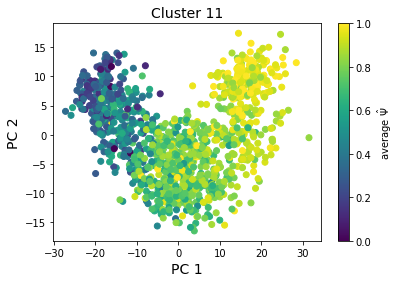

In [362]:
sc = plt.scatter(tiklova_rd.PC_1, tiklova_rd.PC_2, c=tiklova_PSI.loc[clusters[7]].mean(), vmin=0, vmax=1)
plt.colorbar(sc, label='average $\hat{\Psi}$')
plt.xlabel('PC 1', fontsize=14)
plt.ylabel('PC 2', fontsize=14)
plt.title('Cluster 11', fontsize=14)

In [277]:
tiklova_mrna = pd.read_csv('/mnt/lareaulab/cfbuenabadn/data_sc_regulation/tiklova/mrna_counts.tab', 
                           sep='\t', index_col=0)
tiklova_norm = pd.read_csv('/mnt/lareaulab/cfbuenabadn/data_sc_regulation/tiklova/scone_norm_tpm.tab', 
                           sep='\t', index_col=0)

tiklova_mrna = tiklova_mrna[tiklova_PSI.columns]
tiklova_norm = tiklova_norm[tiklova_PSI.columns]

Text(0.5, 1.0, 'PTBP1')

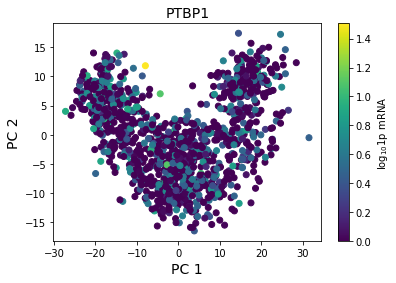

In [296]:
sc = plt.scatter(tiklova_rd.PC_1, tiklova_rd.PC_2, c=np.log10(tiklova_mrna.loc['Ptbp1']+1))
plt.colorbar(sc, label='log$_{10}$1p mRNA')
plt.xlabel('PC 1', fontsize=14)
plt.ylabel('PC 2', fontsize=14)
plt.title('PTBP1', fontsize=14)

Text(0.5, 1.0, 'Ptbp1')

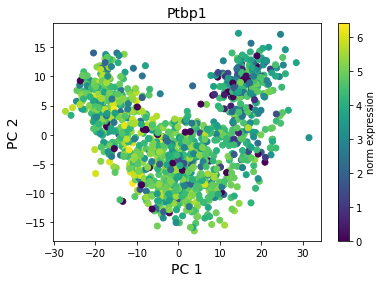

In [298]:
sc = plt.scatter(tiklova_rd.PC_1, tiklova_rd.PC_2, c=tiklova_norm.loc['Ptbp2'])
plt.colorbar(sc, label='norm expression')
plt.xlabel('PC 1', fontsize=14)
plt.ylabel('PC 2', fontsize=14)
plt.title('Ptbp1', fontsize=14)

(0.0, 1.01)

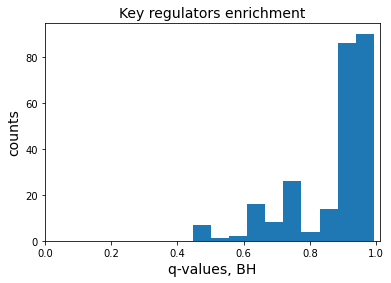

In [259]:
plt.hist(multipletests([x for x in pval_list_mouse if not np.isnan(x)], method='fdr_bh')[1])
plt.xlabel('q-values, BH', fontsize=14)
plt.ylabel('counts', fontsize=14)
plt.title('Key regulators enrichment', fontsize=14)
# plt.title('RBP enrichment, all', fontsize=14)
plt.xlim((0, 1.01))

/mnt/lareaulab/cfbuenabadn/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/mnt/lareaulab/cfbuenabadn/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


(array([12.,  2.,  3.,  5.,  3.,  3.,  1.,  3.,  3.,  1.,  1.,  3.,  1.,
         2.,  3.,  1.,  5.,  4.,  2.,  5.]),
 array([0.00499228, 0.05467909, 0.10436589, 0.15405269, 0.20373949,
        0.25342629, 0.30311309, 0.35279989, 0.40248669, 0.45217349,
        0.50186029, 0.55154709, 0.60123389, 0.6509207 , 0.7006075 ,
        0.7502943 , 0.7999811 , 0.8496679 , 0.8993547 , 0.9490415 ,
        0.9987283 ]),
 <a list of 20 Patch objects>)

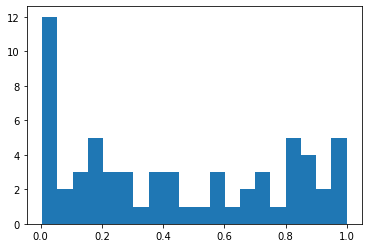

In [129]:
clusters_corr = AC(n_clusters=8).fit_predict(tiklova_PSI_corr.fillna(0))
clusters_corr_dict = {}
for i in range(8):
    clusters_corr_dict.update({i:tiklova_PSI_corr.loc[clusters_corr == i].index})
    
    
clust_list = clusters_corr_dict.keys()
clusters_pval_se = pd.DataFrame(np.zeros((len(clusters_corr_dict.keys()), len(x))))
clusters_pval_e1 = pd.DataFrame(np.zeros((len(clusters_corr_dict.keys()), len(x))))
clusters_pval_e2 = pd.DataFrame(np.zeros((len(clusters_corr_dict.keys()), len(x))))

clusters_pval_se.index = clust_list
clusters_pval_se.columns = x

clusters_pval_e1.index = clust_list
clusters_pval_e1.columns = x

clusters_pval_e2.index = clust_list
clusters_pval_e2.columns = x


pval_list_mouse = []
for c in clusters_corr_dict.keys():
    for rbp in x:
        se_pval = hypergeom_cluster_test(mouse_RBP_se[rbp], clusters_corr_dict[c])
        e1_pval = hypergeom_cluster_test(mouse_RBP_e1[rbp], clusters_corr_dict[c])
        e2_pval = hypergeom_cluster_test(mouse_RBP_e2[rbp], clusters_corr_dict[c])
        
        clusters_pval_se.loc[c, rbp] = se_pval
        clusters_pval_e1.loc[c, rbp] = e1_pval
        clusters_pval_e2.loc[c, rbp] = e2_pval
        
        pval_list_mouse += [se_pval]#, e1_pval, e2_pval]
        
plt.hist(pval_list_mouse, bins=20)

Text(0.5, 1.0, 'PCA of RBPs')

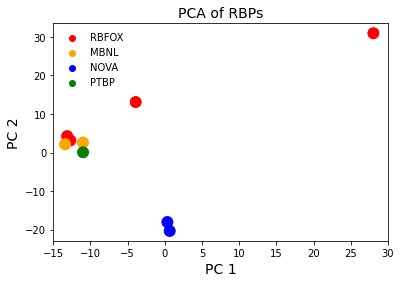

In [208]:
from sklearn.decomposition import PCA
pc = PCA()
pc_rbp = pc.fit_transform(mouse_RBP_binary[x].T)#.shape

human_key = human_RBP_binary[['PTBP1PTBP2', 'RBFOX2']].copy()
human_key.columns = ['hPTBP1PTBP2', 'hRBFOX2']

pc_rbp = pc.fit_transform(pd.concat([mouse_RBP_binary[x], human_key], axis=1).T)#.shape


plt.scatter(pc_rbp.T[0], pc_rbp.T[1], 
            c = ['red', 'red', 'red', 'orange', 'orange', 'blue', 'blue', 'green', 'green', 'red'], s=120)
plt.scatter(-30, 0, c='red', label='RBFOX')
plt.scatter(-30, 0, c='orange', label='MBNL')
plt.scatter(-30, 0, c='blue', label='NOVA')
plt.scatter(-30, 0, c='green', label='PTBP')
plt.xlim([-15, 30])
plt.legend(frameon=False)
plt.xlabel('PC 1', fontsize=14)
plt.ylabel('PC 2', fontsize=14)
plt.title('PCA of RBPs', fontsize=14)

In [202]:
x

['RBFOX1',
 'RBFOX2',
 'RBFOX3',
 'MBNL1MBNL2',
 'MBNL2',
 'NOVA1',
 'NOVA2',
 'PTBP1']

In [201]:
pd.concat([mouse_RBP_binary, human_key], axis=1)

,RBFOX1,RBFOX2,RBFOX3,RBM3,SRRM4,SRSF1,SRSF2,SRSF3,SRSF4,SRSF5,...,LIN28A,MBNL1MBNL2,MBNL1,MBNL2,NOVA1,NOVA2,PABPC1,PTBP1,hPTBP1PTBP2,hRBFOX2
Aamdc_10_e1,0,0,0,0,0,0,1,1,1,1,...,0,0,0,0,1,0,0,1,1,1
Aamdc_10_e2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
Aamdc_10_se,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
Aamdc_9_e1,0,0,0,0,0,0,0,1,1,1,...,0,0,0,0,0,0,0,0,1,0
Aamdc_9_e2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Zyx_1_e2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
Zyx_1_se,0,0,0,0,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,1,1
Zyx_2_e1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
Zyx_2_e2,0,0,0,0,0,0,0,1,0,1,...,0,0,0,0,1,0,0,0,1,1


Text(0.5, 1.0, 'PCA of RBPs')

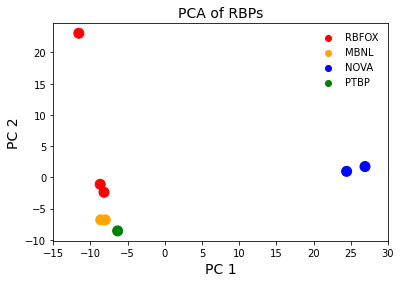

In [185]:
plt.scatter(pc_rbp.T[0], pc_rbp.T[1], c = ['red', 'red', 'red', 'orange', 'orange', 'blue', 'blue', 'green'], s=100)
plt.scatter(-30, 0, c='red', label='RBFOX')
plt.scatter(-30, 0, c='orange', label='MBNL')
plt.scatter(-30, 0, c='blue', label='NOVA')
plt.scatter(-30, 0, c='green', label='PTBP')
plt.xlim([-15, 30])
plt.legend(frameon=False)
plt.xlabel('PC 1', fontsize=14)
plt.ylabel('PC 2', fontsize=14)
plt.title('PCA of RBPs', fontsize=14)

In [170]:
colores = []

for rbp in mouse_RBP_binary.columns[mouse_RBP_binary.sum() >= 100]:
    if 'RBFOX' in rbp:
        colores.append('darkorange')
    elif 'SRSF' in rbp:
        colores.append('darkred')
    elif 'NOVA' in rbp:
        colores.append('blue')
    elif 'MBNL' in rbp:
        colores.append('gold')
    elif 'PTBP' in rbp:
        colores.append('forestgreen')
    else:
        colores.append('grey')

In [171]:
len(colores)

21

In [172]:
mouse_RBP_binary[mouse_RBP_binary.columns[mouse_RBP_binary.sum() >= 100]].shape

(6471, 21)

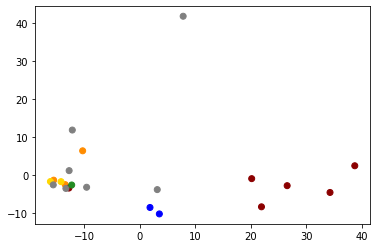

In [174]:
from sklearn.decomposition import PCA
pc = PCA()
pc_rbp = pc.fit_transform(mouse_RBP_binary[mouse_RBP_binary.columns[mouse_RBP_binary.sum() >= 100]].T)#.shape
plt.scatter(pc_rbp.T[0], pc_rbp.T[1], c = colores)

In [105]:
mouse_RBP_se[x].mean()

RBFOX1        0.062123
RBFOX2        0.189615
RBFOX3        0.103848
MBNL1MBNL2    0.081595
MBNL2         0.038479
NOVA1         0.260083
NOVA2         0.289754
PTBP1         0.067687
dtype: float64

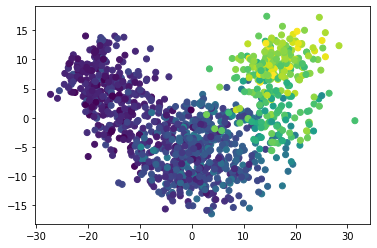

In [137]:
plt.scatter(tiklova_rd.PC_1, tiklova_rd.PC_2, c=tiklova_PSI.loc[clusters[7]].mean())

In [324]:
[x for x in tiklova_psix.index if 'Nptn' in x]

['Nptn_1']

In [325]:
tiklova_psix.loc['Nptn_1']

bin           mean_3_var_1
L_score          0.0207714
pvals          0.000999001
qvals           0.00376853
norm_pvals     6.89863e-07
norm_qvals     3.59018e-06
Name: Nptn_1, dtype: object

In [52]:
hypergeom.sf(-1, 4345, 45, 10)

1.0

In [122]:
# M = 52  # Total number of cards
# n = 26  # Number of Type I cards (e.g. red cards) 
# N = 5   # Number of draws (5 cards dealt in one poker hand)
# k = 3   # Number of Type I cards we want in one hand

def hyper_test(M, n, N, k):
    '''
    Calculates the hypergeometric test.
    
    Input:
      M: Population size (total exons tested)
      n: Successess in population (exons with p-value <= x)
      N: Sample size (exons selected)
      k: Successes in sample (selected exons with p-value <= x)
    Output:
      p_depleted: p-value of depletion from the hypergeometric test
      p_enriched: p-value of enrichment from the hypergeometric test
    '''
    hpd = hypergeom(M, n, N) # Hypergeometric distribution
    p_depleted = hpd.cdf(k)  # Get cummulative distribution up to k
    p_enriched = hpd.sf(k-1) # Survival function up to k-1 (1 - cdf(k-1))
    return p_depleted, p_enriched

In [123]:
hyper_test(4345, 45, 10, 0)[0]

0.9010307405954722

(array([ 21.,  33.,  26.,  27.,  40.,  36.,  38.,  46.,  37.,  34.,  23.,
         42.,  62.,  37.,  42.,  39.,  39.,  13.,  13., 702.]),
 array([0.00814389, 0.05773669, 0.1073295 , 0.1569223 , 0.20651511,
        0.25610791, 0.30570072, 0.35529353, 0.40488633, 0.45447914,
        0.50407194, 0.55366475, 0.60325755, 0.65285036, 0.70244317,
        0.75203597, 0.80162878, 0.85122158, 0.90081439, 0.95040719,
        1.        ]),
 <a list of 20 Patch objects>)

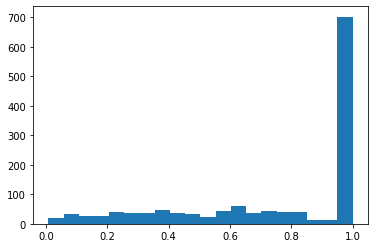

In [157]:
pval_list_mouse = []
for c in clusters.keys():
    for rbp in mouse_RBP_se.columns:
        pval_list_mouse.append(fisher_test(mouse_RBP_se[rbp], clusters[c]))
        pval_list_mouse.append(fisher_test(mouse_RBP_e1[rbp], clusters[c]))
        pval_list_mouse.append(fisher_test(mouse_RBP_e2[rbp], clusters[c]))
        
plt.hist(pval_list_mouse, bins=20)

(array([68., 41., 43., 28., 32., 32., 26., 32., 29., 27., 26., 29., 34.,
        28., 18., 25., 31., 32., 24., 25.]),
 array([3.77329225e-04, 5.03053582e-02, 1.00233387e-01, 1.50161416e-01,
        2.00089445e-01, 2.50017474e-01, 2.99945503e-01, 3.49873532e-01,
        3.99801561e-01, 4.49729590e-01, 4.99657619e-01, 5.49585648e-01,
        5.99513677e-01, 6.49441706e-01, 6.99369735e-01, 7.49297764e-01,
        7.99225793e-01, 8.49153822e-01, 8.99081851e-01, 9.49009880e-01,
        9.98937909e-01]),
 <a list of 20 Patch objects>)

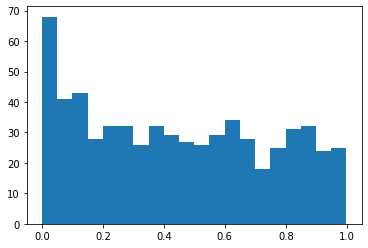

In [98]:
pval_list = []
for c in clusters.keys():
    for rbp in human_RBP_se.columns:
        pval_list.append(hypergeom_cluster_test(human_RBP_se[rbp], clusters[c]))
        pval_list.append(hypergeom_cluster_test(human_RBP_e1[rbp], clusters[c]))
        pval_list.append(hypergeom_cluster_test(human_RBP_e2[rbp], clusters[c]))

plt.hist(pval_list, bins=20)

100%|██████████| 100/100 [00:35<00:00,  2.78it/s]


(array([369., 305., 309., 290., 321., 298., 326., 317., 331., 347., 309.,
        342., 378., 367., 387., 364., 383., 394., 467., 439.]),
 array([0.        , 0.04999964, 0.09999928, 0.14999892, 0.19999856,
        0.24999821, 0.29999785, 0.34999749, 0.39999713, 0.44999677,
        0.49999641, 0.54999605, 0.59999569, 0.64999533, 0.69999498,
        0.74999462, 0.79999426, 0.8499939 , 0.89999354, 0.94999318,
        0.99999282]),
 <a list of 20 Patch objects>)

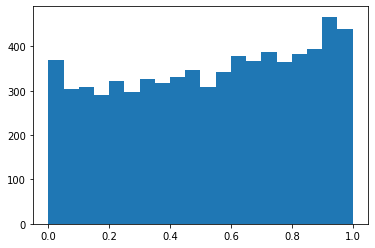

In [262]:
pval_list_r = []

for i in tqdm(range(100)):
    cluster_size = np.random.randint(2, 350)
    cluster_random = np.random.choice(mouse_RBP_se.index, cluster_size)
    
    for rbp in mouse_RBP_se.columns:
    
#     for rbp in x:
        pval_list_r.append(hypergeom_cluster_test(mouse_RBP_se[rbp], cluster_random))
        pval_list_r.append(hypergeom_cluster_test(mouse_RBP_e1[rbp], cluster_random))
        pval_list_r.append(hypergeom_cluster_test(mouse_RBP_e2[rbp], cluster_random))
        
plt.hist(pval_list_r, bins=20)

Text(0.5, 1.0, 'RBP in random clusters')

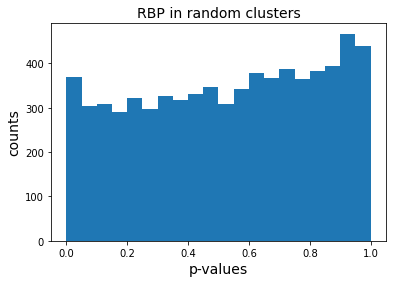

In [264]:
plt.hist(pval_list_r, bins=20)
plt.xlabel('p-values', fontsize=14)
plt.ylabel('counts', fontsize=14)
plt.title('RBP in random clusters', fontsize=14)
# plt.title('Key regulators in random clusters', fontsize=14)

In [ ]:
pval_list = []

for i in tqdm(range(200)):
    cluster_size = np.random.randint(2, 350)
    cluster_random = np.random.choice(mouse_RBP_se.index, cluster_size)
    
    for rbp in mouse_RBP_se.columns:
        pval_list.append(fisher_test(mouse_RBP_se[rbp], cluster_random))
        pval_list.append(fisher_test(mouse_RBP_e1[rbp], cluster_random))
        pval_list.append(fisher_test(mouse_RBP_e2[rbp], cluster_random))
        
plt.hist(pval_list, bins=20)

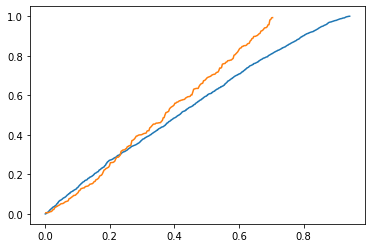

In [214]:
import numpy as np 
import pylab 
import scipy.stats as stats

prb = stats.probplot(pval_list_r, dist="uniform")
plt.plot(prb[0][0], prb[0][1])

prb = stats.probplot(pval_list_mouse, dist="uniform")
plt.plot(prb[0][0], prb[0][1])

/mnt/lareaulab/cfbuenabadn/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/mnt/lareaulab/cfbuenabadn/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


(array([10.,  6.,  9.,  4.,  7.,  3., 10.,  5.,  6.,  4.,  2.,  5.,  5.,
         3.,  5.,  2.,  7.,  3.,  4.,  7.,  7.,  4.,  8.,  5.,  2.,  5.,
         2.,  4., 10.,  8.,  3.,  6.,  3.,  4.,  7.,  7.,  2.,  3.,  8.,
         5.,  4.,  3.,  8.,  3.,  4.,  8.,  3.,  5.,  2.,  4.]),
 array([0.00624471, 0.02597684, 0.04570897, 0.0654411 , 0.08517323,
        0.10490536, 0.12463749, 0.14436962, 0.16410175, 0.18383388,
        0.20356601, 0.22329814, 0.24303026, 0.26276239, 0.28249452,
        0.30222665, 0.32195878, 0.34169091, 0.36142304, 0.38115517,
        0.4008873 , 0.42061943, 0.44035156, 0.46008369, 0.47981582,
        0.49954795, 0.51928008, 0.53901221, 0.55874434, 0.57847647,
        0.5982086 , 0.61794073, 0.63767286, 0.65740499, 0.67713712,
        0.69686925, 0.71660138, 0.73633351, 0.75606564, 0.77579776,
        0.79552989, 0.81526202, 0.83499415, 0.85472628, 0.87445841,
        0.89419054, 0.91392267, 0.9336548 , 0.95338693, 0.97311906,
        0.99285119]),
 <a list of 50

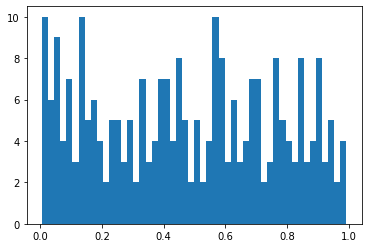

In [219]:
plt.hist(pval_list_mouse, bins=50)

In [74]:
from scipy.stats import fisher_exact

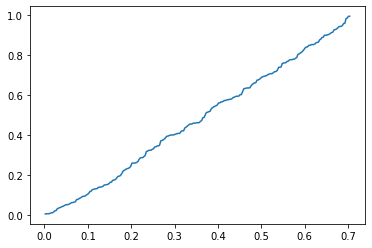

In [218]:
prb = stats.probplot(pval_list_mouse, dist="uniform")
plt.plot(prb[0][0], prb[0][1])

In [76]:
def fisher_test(rbp_binding, clusters):
    pval = fisher_exact(
        [[len(rbp_binding.index), rbp_binding.sum()], 
         [len(clusters), rbp_binding.loc[clusters].sum()]]
    )
    return pval[1]

100%|██████████| 10/10 [01:12<00:00,  7.25s/it]


(array([ 14.,  21.,  27.,  20.,  23.,  27.,  20.,  33.,  34.,  38.,  30.,
         43.,  54.,  31.,  53.,  39.,  43.,  28.,  21., 301.]),
 array([0.00364587, 0.05346358, 0.10328129, 0.15309899, 0.2029167 ,
        0.2527344 , 0.30255211, 0.35236982, 0.40218752, 0.45200523,
        0.50182294, 0.55164064, 0.60145835, 0.65127606, 0.70109376,
        0.75091147, 0.80072917, 0.85054688, 0.90036459, 0.95018229,
        1.        ]),
 <a list of 20 Patch objects>)

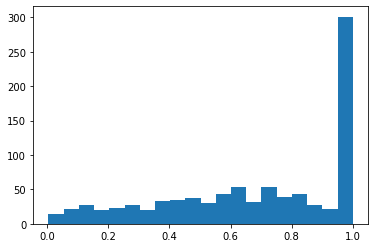

In [78]:
pval_list = []

for i in tqdm(range(10)):
    cluster_size = np.random.randint(2, 350)
    cluster_random = np.random.choice(mouse_RBP_se.index, cluster_size)
    
    for rbp in mouse_RBP_se.columns:
        pval_list.append(fisher_test(mouse_RBP_se[rbp], cluster_random))
        pval_list.append(fisher_test(mouse_RBP_e1[rbp], cluster_random))
        pval_list.append(fisher_test(mouse_RBP_e2[rbp], cluster_random))
        
plt.hist(pval_list, bins=20)

In [79]:
tiklova_neurogenesis_psix_extended = pd.read_csv('~/sc_splicing_regulation/psix_runs/tiklova_neurogenesis.scores.txt',
                                                 sep='\t', index_col=0)

tiklova_psix_extended = pd.read_csv('~/sc_splicing_regulation/psix_runs/tiklova.scores.txt',
                                                 sep='\t', index_col=0)

In [91]:
list_exons_extended = (tiklova_neurogenesis_psix_extended.index | tiklova_psix_extended.index)
list_exons = (tiklova_psix.index | tiklova_all_psix.index)


In [92]:
list_exons

Index(['Aamdc_10', 'Aamdc_9', 'Aamdc_nmdSE_2', 'Aasdhppt_2', 'Abat_3',
       'Abca3_4', 'Abhd10_1', 'Abhd10_2', 'Abhd14a_1', 'Abhd14a_3',
       ...
       'Zmiz1_1', 'Zmiz2_8', 'Zmym3_7', 'Zmynd11_7', 'Zmynd8_6', 'Zmynd8_8',
       'Znhit1_1', 'Zscan18_1', 'Zyx_1', 'Zyx_2'],
      dtype='object', length=2157)

In [98]:
[x for x in list_exons_extended if x not in list_exons]

1807

In [100]:
fh = open('/mnt/lareaulab/cfbuenabadn/Network/Mouse/SplicingNetwork/L_score_events/tiklova/exons_list_extended.txt', 'w')
for x in [x for x in list_exons_extended if x not in list_exons]:
    fh.write(x+'\n')
    
fh.close()

In [101]:
6471/5421

1.1936912008854454

In [102]:
2157/1807

1.1936912008854454